# Real Estate Price Prediction in the UAE Using Machine Learning and Web-Scraped Data.

### M00977896 Nishita Chaudhary

# Importing Librabries for Rent dataset

In [1]:
#For data manipulate
import pandas as pd
import numpy as np
#For visualization
import seaborn as sns
import matplotlib.pyplot as plt

#lable encoding
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# For Model building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from tensorflow import keras
from tensorflow.keras import layers
# Evalution Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [68]:
df_r= pd.read_csv('rent.csv')
df_r.head()

,Unnamed: 0,title,latitude,longitude,Locality,Region,Country,price,type,address,beds,baths,completion_status,furnishing,description,post_date,Reference,area,agency_name,purpose
0,0,Premium Living | Best Location | 1BR + Study Room,25.066330,55.207544,Jumeirah Village Circle (JVC),Dubai,UAE,"80,000",Apartment,"La Vita Bella, JVC District 10, Jumeirah Villa...",1 Bed,2 Baths,Ready,Unfurnished,Azco Real Estate is thrilled to offer a stunni...,29 April 2024,Bayut - JVC-DVP-SD-LAVITA-1BR-1,814 sqft,AZCO - Lease JVC,to rent
1,1,First Tenant-Luxury Living-Ready to Move-Call Now,25.156479,55.284703,Mohammed Bin Rashid City,Dubai,UAE,"95,000",Apartment,"Residences 16, The Residences at District One,...",1 Bed,2 Baths,Ready,Unfurnished,House & Hedges Real Estate is pleased to offer...,8 July 2024,Bayut - 102164-VyInfQ,775 sqft,House and Hedges Real Estate,to rent
2,2,Creek View | High Floor | Exclusive Apartment,25.209493,55.343746,Dubai Creek Harbour,Dubai,UAE,"220,000",Apartment,"Address Harbour Point Tower 2, Address Harbour...",2 Beds,2 Baths,Ready,Furnished,Hamptons International are proud to exclusivel...,17 July 2024,Bayut - HI-R-02091,"1,103 sqft",Hamptons International - Leasing,to rent
3,3,Chiller Free | Prime Location | Near Metro,25.188615,55.259659,Business Bay,Dubai,UAE,"96,999",Apartment,"Tiara West Tower, Tiara United Towers, Busines...",1 Bed,2 Baths,Ready,Unfurnished,"HIghline Real Estate, is pleased to present th...",10 May 2024,Bayut - NK01,880 sqft,Highline Real Estate,to rent
4,4,Community View | Spacious Unit | Big balcony,25.067659,55.213589,Jumeirah Village Circle (JVC),Dubai,UAE,"70,000",Apartment,"Maison VI, JVC District 11, Jumeirah Village C...",1 Bed,1 Bath,Ready,Unfurnished,Azco Real Estate is pleased to offer this lavi...,30 May 2024,Bayut - JVC-DVP-SD-MAISON6-1BR,839 sqft,AZCO - Lease JVC,to rent


In [69]:
len(df_r)

74636

# Data Cleaning 

## Removing duplicates

In [70]:
# Checking duplicates and found that there are no duplicates
df_r.duplicated().sum()

0

### Manipulating rent columns 

In [71]:
#Extracting the area data by removing comma and "sqft".
def extract_last_number(text):
    numbers = [num.replace(',', '') for num in text.split() if num.replace(',', '').isdigit()]
    return numbers[-1] if numbers else None
df_r['area'] = df_r['area'].astype(str)

df_r['area'] = df_r['area'].apply(extract_last_number)

df_r['area'] = pd.to_numeric(df_r['area'], errors='coerce')

print(df_r[['area']])

         area
0       814.0
1       775.0
2      1103.0
3       880.0
4       839.0
...       ...
74631   836.0
74632   900.0
74633  2455.0
74634   758.0
74635   813.0

[74636 rows x 1 columns]


In [72]:
# Extracting the price data by removing coma and making it integer
df_r['price'] = pd.to_numeric(df_r['price'].str.replace(',', ''), errors='coerce')
df_r['price'] = df_r['price'].fillna(0)
df_r['price'] = df_r['price'].astype(int)

In [73]:
#Replace with 0 as it have only studio room can be seen in name column
# Extract the number of beds or 'Studio'
df_r['beds'] = df_r['beds'].str.extract(r'(\d+|Studio)', expand=False)

# Replace 'Studio' with 0
df_r['beds'] = df_r['beds'].replace('Studio', 0)
df_r['beds'] = pd.to_numeric(df_r['beds'], errors='coerce')
df_r['baths'] = df_r['baths'].str.extract(r'(\d+)', expand=False)


### Checking null values and Handling null values

In [74]:
#Checking null values greater than 80%
null_percentage = df_r.isnull().mean() * 100  

#filtering more 80% null values
columns_with_high_nulls = null_percentage[null_percentage > 80].index
print(f"Columns with more than 80% null values:\n{null_percentage[null_percentage > 80]}")


Columns with more than 80% null values:
Series([], dtype: float64)


In [75]:
# From the above cell its clear that there are no null values more than 80%

In [76]:
#Initially There were 22 columns by scrapping.
unwanted_columns_rent = ['Unnamed: 0', 'Reference'] 
df_r = df_r.drop(columns=unwanted_columns_rent)

In [77]:
#Checking null values
df_r.isnull().sum()

title                   0
latitude                0
longitude               0
Locality                0
Region                  0
Country                 0
price                   0
type                   14
address                 0
beds                    0
baths                   0
completion_status       0
furnishing           4514
description             0
post_date              14
area                 2914
agency_name            21
purpose                 0
dtype: int64

In [78]:
#For continous data filled with mean and for category data filled with mode.
df_r['type'].fillna(df_r['type'].mode()[0], inplace=True)
df_r['furnishing'].fillna(df_r['furnishing'].mode()[0], inplace=True)
df_r['post_date'].fillna(method='ffill', inplace=True)
df_r['area'].fillna(df_r['area'].mean(), inplace=True)
df_r['agency_name'].fillna(df_r['agency_name'].mode()[0], inplace=True)


<ipython-input-78-226b98085335>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_r['post_date'].fillna(method='ffill', inplace=True)


In [79]:
#Checking the null values again
df_r.isnull().sum()

title                0
latitude             0
longitude            0
Locality             0
Region               0
Country              0
price                0
type                 0
address              0
beds                 0
baths                0
completion_status    0
furnishing           0
description          0
post_date            0
area                 0
agency_name          0
purpose              0
dtype: int64

## Checking Datatypes

In [80]:
df_r.dtypes

title                 object
latitude             float64
longitude            float64
Locality              object
Region                object
Country               object
price                  int32
type                  object
address               object
beds                   int64
baths                 object
completion_status     object
furnishing            object
description           object
post_date             object
area                 float64
agency_name           object
purpose               object
dtype: object

In [81]:
#Converting post date to datetime and address to string.
from datetime import date
df_r['post_date'] = pd.to_datetime(df_r['post_date']) 
df_r['address'] = df_r['address'].astype(str)
df_r['beds'] = df_r['beds'].astype(int)
df_r['baths'] = df_r['baths'].astype(int)
df_r.dtypes

title                        object
latitude                    float64
longitude                   float64
Locality                     object
Region                       object
Country                      object
price                         int32
type                         object
address                      object
beds                          int32
baths                         int32
completion_status            object
furnishing                   object
description                  object
post_date            datetime64[ns]
area                        float64
agency_name                  object
purpose                      object
dtype: object

In [82]:
#initializing coloums to analyse
columns_to_analyze_rent = ['price', 'area', 'beds', 'baths']

# Statistical analysis for sales columns
statistical_summary_rent = df_r[columns_to_analyze_rent].agg(['count', 'mean', 'median', 'std', 'min', 'max']).T

statistical_summary_rent.columns = ['number', 'mean', 'median', 'sd', 'min', 'max']

# Display the statistical summary
print("Statistical Summary:")
print(statistical_summary_rent)


Statistical Summary:
        number           mean    median             sd    min         max
price  74636.0  178766.834222  119000.0  311397.919626    0.0  18000000.0
area   74636.0    1534.681716    1055.0    3274.447048  118.0    430556.0
beds   74636.0       1.775497       2.0       1.374890    0.0        11.0
baths  74636.0       2.496047       2.0       1.483930    1.0        11.0


# Feature Extraction

It improves the efficiency and accuracy of machine learning models through extracting the necessary information from a data set.

In [83]:
# Extracting year, month, and day
df_r['year'] = df_r['post_date'].dt.year
df_r['month'] = df_r['post_date'].dt.month
df_r['day'] = df_r['post_date'].dt.day
df_r['quarter'] = df_r['post_date'].dt.quarter


In [84]:
#extracting building name from address
df_r.loc[:, 'building_name'] = df_r['address'].str.split(',', expand=True)[0]


In [85]:
# Categorize the Properties into 4 sections 
def cat_property(price):
     if price < 200000:
        return 'Affordable'
     elif 200000 <= price < 400000:
        return 'Mid-range'
     elif 400000 <= price < 600000:
        return 'Premium'
     else:
        return 'Luxury'
        
df_r.loc[:, 'price_category'] = df_r['price'].apply(cat_property)



In [86]:
# Extracting price_per_sq_unit using price and area
df_r['price_per_sq_unit'] = (df_r['price'] / df_r['area']).round(2)
df_r['price_per_sq_unit'] 

0         98.28
1        122.58
2        199.46
3        110.23
4         83.43
          ...  
74631     59.81
74632     57.78
74633    114.05
74634    164.91
74635    153.75
Name: price_per_sq_unit, Length: 74636, dtype: float64

In [87]:
# From EDA Analyis Replacing 'Al ain' with 'Abu dhabi' in the 'Region' column as it is the part of emirate Abu Dhabi
df_r['Region'] = df_r['Region'].replace('Al Ain', 'Abu Dhabi')


In [88]:
# Dropping other columns 
dcolumn = [ 'title','address', 'purpose', 'Country', 'post_date', 'description',  'completion_status',  'agency_name', 'building_name' ]
df_r= df_r.drop(columns=dcolumn)

## Checking & Removing Outliers

In [98]:
#Checking the outliers for price coloumn
Q1 = df_r['price'].quantile(0.25)
Q3 = df_r['price'].quantile(0.75)
IQR = Q3 - Q1
df_r = df_r[(df_r['price'] >= (Q1 - 1.5 * IQR)) & (df_r['price'] <= (Q3 + 1.5 * IQR))]
len(df_r)

69002

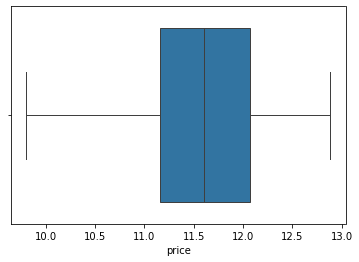

In [99]:
#using box plott to visualize the price outlier.
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(x=df_r['price'])
plt.show()


In [100]:
# As the price value are in millions so taking the log of price.
df_r['price'] = np.log1p(df_r['price'])

In [101]:
# From the below analysis year month is the import coloumns and cannot be dropped
#This encoding helps improve model performance by accurately reflecting the relationships between months and quarters, allowing for
#better predictions analysis.
df_r['month'] = np.sin(2 * np.pi * df_r['month'] / 12)
df_r['month'] = np.cos(2 * np.pi * df_r['month'] / 12)

# Cyclic encoding for quarter
df_r['quarter'] = np.sin(2 * np.pi * df_r['quarter'] / 4)
df_r['quarter'] = np.cos(2 * np.pi * df_r['quarter'] / 4)

In [102]:
# Standerdizing the data by using lableencoder for categorical variable and minmax scalar for numerical variable.
#14 variables are independent variables and one price as dependent variable.
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

#Initialize LabelEncoder and minmaxscalar
le = LabelEncoder()
scaler = MinMaxScaler()

#Apply LabelEncoder for categorical columns
categorical_columns = ['Locality',  'furnishing',  'Region', 'type',  'price_category']
for column in categorical_columns:
    df_r[column] = le.fit_transform(df_r[column].astype(str))

#Apply minmaxscalar for numerical columns
numerical_columns = [  'area', 'beds', 'baths', 'latitude','longitude', 'price_per_sq_unit', 'year', 'month', 'day']
df_r[numerical_columns] = scaler.fit_transform(df_r[numerical_columns])

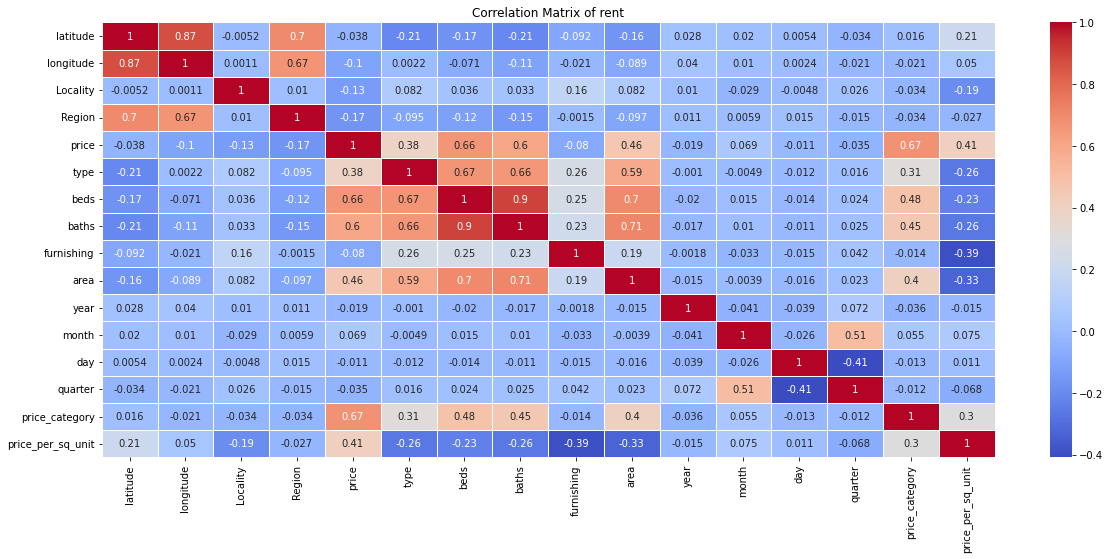

In [103]:
# plotthe correlation matrix to rent data
corr_matrix = df_r.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of rent')
plt.show()



# Model training and testing 

In [104]:
# Define X and y 
# Price is the target column
X = df_r.drop('price', axis=1)
y = df_r['price']

#Splitting the data into 70% training and test 30% testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature Importance

              Feature  Coefficient
14  price_per_sq_unit     0.581511
5                beds     0.246892
8                area     0.143907
0            latitude     0.131028
6               baths     0.032938
13     price_category     0.018930
9                year     0.018033
10              month     0.005283
4                type     0.000827
2            Locality    -0.000053
11                day    -0.003203
12            quarter    -0.003686
3              Region    -0.004203
7          furnishing    -0.004462
1           longitude    -0.147452


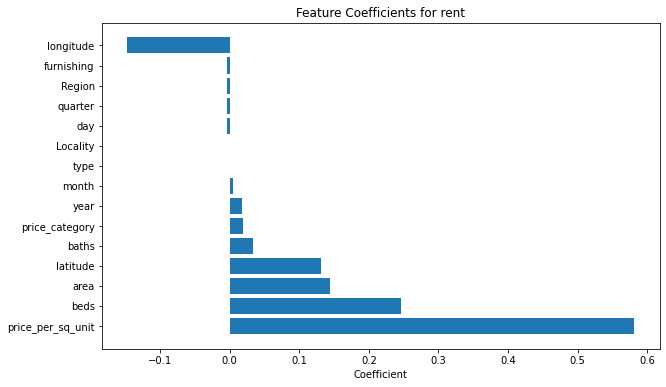

In [105]:
#Fiting a linear regression model
lin_model = LinearRegression()
lin_model.fit(X, y)

# Getting all feature coefficients
coef = lin_model.coef_
#For tabluar data
coef_importance_rent = pd.DataFrame({'Feature': X.columns, 'Coefficient': coef})
coef_importance_rent = coef_importance_rent.sort_values(by='Coefficient', ascending=False)

print(coef_importance_rent)

# Plotting the coefficients
plt.figure(figsize=(10, 6))
plt.barh(coef_importance_rent['Feature'], coef_importance_rent['Coefficient'])
plt.xlabel('Coefficient')
plt.title('Feature Coefficients for rent')
plt.show()


## 1.  LinearRegression

Training R2 Score of rent: 0.8250221305371295
R2 Score of rent: 0.8231548423656398
Mean Absolute Error (MAE) of rent regression : 0.015882908275909907
Mean Squared Error (MSE) of rent regression: 0.00044319757937436916
Root Mean Squared Error (RMSE) of rent regression: 0.02105225829630563


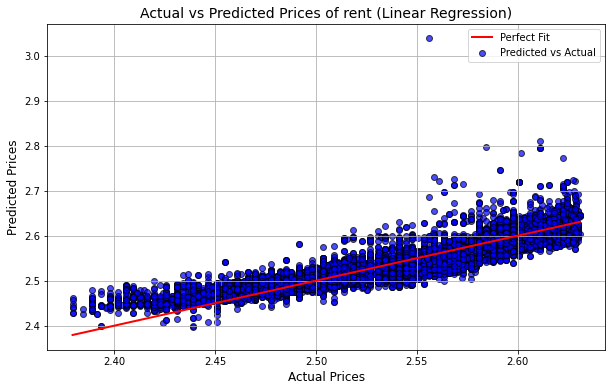

In [106]:
# Training Linear regression model
model_linear_r = LinearRegression()
model_linear_r.fit(X_train, y_train)

# Predicting using the testing data
y_pred = model_linear_r.predict(X_test)

# Calculate regression metrics
mae_r_reg = mean_absolute_error(y_test, y_pred)
mse_r_reg = mean_squared_error(y_test, y_pred)
rmse_r_reg = np.sqrt(mse_r_reg)
r2_r_reg = r2_score(y_test, y_pred)
# Predicting using the training data
y_train_pred = model_linear_r.predict(X_train)

# Calculate regression metrics for training set
r2_train_r = r2_score(y_train, y_train_pred)

# Display the training results
print(f"Training R2 Score of rent: {r2_train_r}")

# Display the results
print(f"R2 Score of rent: {r2_r_reg}")
print(f"Mean Absolute Error (MAE) of rent regression : {mae_r_reg}")
print(f"Mean Squared Error (MSE) of rent regression: {mse_r_reg}")
print(f"Root Mean Squared Error (RMSE) of rent regression: {rmse_r_reg}")

# Plotting the Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolors='k', alpha=0.7, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2, label='Perfect Fit')

# Adding titles and labels
plt.title('Actual vs Predicted Prices of rent (Linear Regression)', fontsize=14)
plt.xlabel('Actual Prices', fontsize=12)
plt.ylabel('Predicted Prices', fontsize=12)
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()



## 2.  Lasso

In [107]:
#Initialize and train the Lasso Regression model with random alpha
model_lasso = Lasso(alpha=0.001)  
model_lasso.fit(X_train, y_train)

# Predict on the test set rent data
y_pred = model_lasso.predict(X_test)
r_2_r = r2_score(y_test, y_pred)
y_train_pred = model_lasso.predict(X_train)

# Calculate regression metrics for training set
r2_train_lasso_rent = r2_score(y_train, y_train_pred)
print(f"Training R2 Score of rent: {r2_train_lasso_rent}")

#calculate lasso metrics rent data
mae_r_l = mean_absolute_error(y_test, y_pred)
mse_r_l = mean_squared_error(y_test, y_pred)
rmse_r_l = np.sqrt(mse_r_l)
r2_rent_l = r2_score(y_test, y_pred)

#display the results
print(f"R2 Score lasso: {r2_rent_l}")
print(f"Mean Absolute Error (MAE) to rent lasso : {mae_r_l}")
print(f"Mean Squared Error (MSE) to rent lasso : {mse_r_l}")
print(f"Root Mean Squared Error (RMSE) to rent lasso: {rmse_r_l}")


Training R2 Score of rent: 0.598005542337401
R2 Score lasso: 0.5950208256608961
Mean Absolute Error (MAE) to rent lasso : 0.025684823353013093
Mean Squared Error (MSE) to rent lasso : 0.0010149318882410174
Root Mean Squared Error (RMSE) to rent lasso: 0.03185799567206037


In [108]:
# Define the grid of alpha values to search over 
param_grid = {'alpha': [0.11, 0.01, 10,  0.0001, 100]}

# Initialize the GridSearchCV object with params and crossvalidation to find best alpha 
grid_search = GridSearchCV(estimator=Lasso(), param_grid=param_grid, cv=9)
grid_search.fit(X_train, y_train)

best_lasso_model = grid_search.best_estimator_

# Get the best alpha from the grid search
best_alpha = grid_search.best_params_['alpha']
y_pred_best = best_lasso_model.predict(X_test)

y_train_pred = best_lasso_model.predict(X_train)

# Calculate regression metrics for training set
r2_train_l_rent = r2_score(y_train, y_train_pred)
print(f"Training R2 Score of rent: {r2_train_l_rent}")
#evaluatiometrics lasso
r2_lasso_alpha = r2_score(y_test, y_pred_best)
mse_best_lasso_alpha  = mean_squared_error(y_test, y_pred_best)
mae_lasso_alpha  = mean_absolute_error(y_test, y_pred_best)
rmse_lasso_alpha = np.sqrt(mse_best_lasso_alpha)


# Print results lasso best alpha
print(f"Best alpha value selected: {best_alpha}")
print(f'R2 (Lasso alpha) to rent: {r2_lasso_alpha}')
print(f"Mean Squared Error with best alpha to rent : {mse_best_lasso_alpha}")
print(f"Mean Absolute Error to rent: {mae_lasso_alpha}")
print(f"Root Mean Squared Error (RMSE) to rent lasso with best alpha: {rmse_lasso_alpha}")




Training R2 Score of rent: 0.806626335019707
Best alpha value selected: 0.0001
R2 (Lasso alpha) to rent: 0.8036131698177007
Mean Squared Error with best alpha to rent : 0.0004921716202021088
Mean Absolute Error to rent: 0.017254764508900875
Root Mean Squared Error (RMSE) to rent lasso with best alpha: 0.022184941293636743


# Xgboost

Training R2 Score of rent: 0.9993909996704221
R2 xgb to rent: 0.999181749160496
Mean Squared Error xgb to rent : 2.050645865797659e-06
Mean Absolute Error to rent: 0.0010123290444151035
Root Mean Squared Error (RMSE) xgb to rent: 0.0014320076346855345


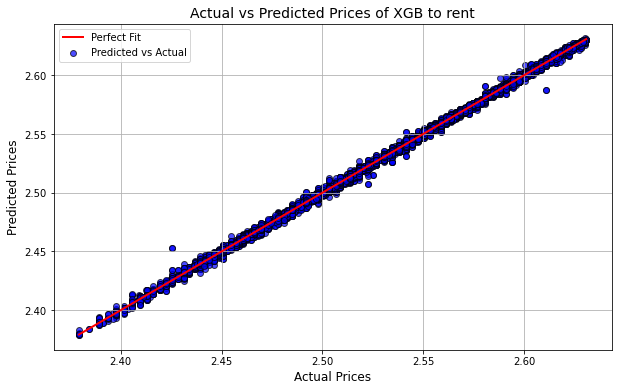

In [109]:
# intitialize the XGB regrssor
model_xgb_r = xgb.XGBRegressor(objective='reg:squarederror')
model_xgb_r.fit(X_train, y_train)
y_pred = model_xgb_r.predict(X_test)

#evaluation and printing values of rent data
mae_xr = mean_absolute_error(y_test, y_pred)
mse_xr = mean_squared_error(y_test, y_pred)
r2_xr = r2_score(y_test, y_pred)
rmse_xr = np.sqrt(mse_xr)
y_train_pred = model_xgb_r.predict(X_train)

# Calculate regression metrics for training set
r2_train_xgb_rent = r2_score(y_train, y_train_pred)
print(f"Training R2 Score of rent: {r2_train_xgb_rent}")

# Print evaluation metrics of xgb
print(f'R2 xgb to rent: {r2_xr}')
print(f"Mean Squared Error xgb to rent : {mse_xr}")
print(f"Mean Absolute Error to rent: {mae_xr}")
print(f"Root Mean Squared Error (RMSE) xgb to rent: {rmse_xr}")

# Plotting the Actual vs Predicted values xgb rent
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolors='k', alpha=0.7, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2, label='Perfect Fit')

plt.title('Actual vs Predicted Prices of XGB to rent', fontsize=14)
plt.xlabel('Actual Prices', fontsize=12)
plt.ylabel('Predicted Prices', fontsize=12)
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()

Training R2 Score of rent hyperparameter: 0.9659831918415239
R2 XGB after hyperparameter tuning to rent: 0.9653703237078264
Mean Squared Error XGB after hyperparameter tuning to rent: 8.678659292974237e-05
Mean Absolute Error XGB after hyperparameter tuning to rent: 0.007493212166106015
Root Mean Squared Error (RMSE) XGB after hyperparameter tuning to rent: 0.009315932209378854


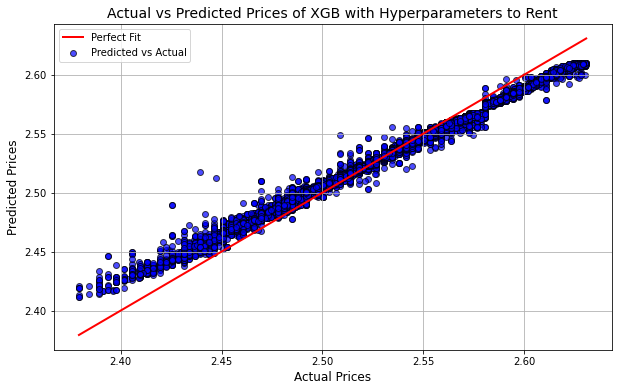

In [110]:
#initilize the xgb model with hyperparameter
model_xgb_r_h = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=17, learning_rate=0.1, max_depth=8)
model_xgb_r_h.fit(X_train, y_train)
y_pred_hyper = model_xgb_r_h.predict(X_test)

#model evaluation and printing values of rent data
mae_xr_hyper = mean_absolute_error(y_test, y_pred_hyper)
mse_xr_hyper = mean_squared_error(y_test, y_pred_hyper)
r2_xr_hyper = r2_score(y_test, y_pred_hyper)
rmse_xr_hyper = np.sqrt(mse_xr_hyper)

y_train_pred = model_xgb_r_h.predict(X_train)

# Calculate regression metrics for training set
r2_train_xgbhyper_rent = r2_score(y_train, y_train_pred)
print(f"Training R2 Score of rent hyperparameter: {r2_train_xgbhyper_rent}")

# Print evaluation metrics of xgb parameter
print(f'R2 XGB after hyperparameter tuning to rent: {r2_xr_hyper}')
print(f"Mean Squared Error XGB after hyperparameter tuning to rent: {mse_xr_hyper}")
print(f"Mean Absolute Error XGB after hyperparameter tuning to rent: {mae_xr_hyper}")
print(f"Root Mean Squared Error (RMSE) XGB after hyperparameter tuning to rent: {rmse_xr_hyper}")
# plot xgb hyperparameter
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_hyper, color='blue', edgecolors='k', alpha=0.7, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2, label='Perfect Fit')

plt.title('Actual vs Predicted Prices of XGB with Hyperparameters to Rent', fontsize=14)
plt.xlabel('Actual Prices', fontsize=12)
plt.ylabel('Predicted Prices', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Random Forest

Training R2 Score of rent  0.999937923692287
R2: 0.9995813617827475
Mean Absolute Error (MAE) Random Forest for rent: 0.00023735093762913492
Mean Squared Error (MSE) Random Forest for rent: 1.0491632736902994e-06
Root Mean Squared Error (RMSE) Random Forest for rent: 0.0010242867145923056


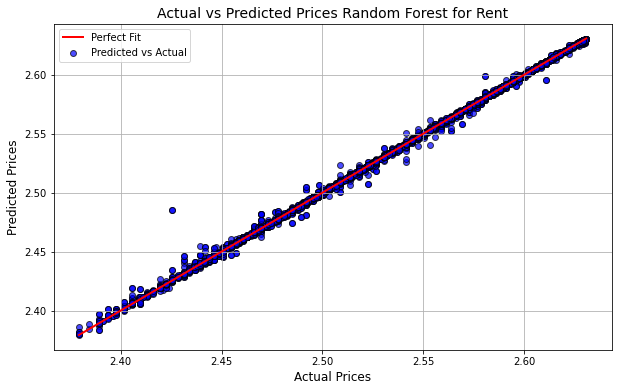

In [111]:
#initialize the random forest model
model_random_r = RandomForestRegressor(random_state=42)  
model_random_r.fit(X_train, y_train)

# Predict on the test set for rent data
y_pred_rf = model_random_r.predict(X_test)

#evaluat and print values for rent data
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_random = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

y_train_pred = model_random_r.predict(X_train)

# Calculate regression metrics for training set
r2_train_random_rent = r2_score(y_train, y_train_pred)
print(f"Training R2 Score of rent  {r2_train_random_rent}")

# Print evaluation metrics of random forest
print(f"R2: {r2_random}")
print(f"Mean Absolute Error (MAE) Random Forest for rent: {mae_rf}")
print(f"Mean Squared Error (MSE) Random Forest for rent: {mse_rf}")
print(f"Root Mean Squared Error (RMSE) Random Forest for rent: {rmse_rf}")

# Plotting the Actual vs Predicted values of random foret
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, color='blue', edgecolors='k', alpha=0.7, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2, label='Perfect Fit')

plt.title('Actual vs Predicted Prices Random Forest for Rent', fontsize=14)
plt.xlabel('Actual Prices', fontsize=12)
plt.ylabel('Predicted Prices', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Training R2 Score of rent hyperparameter: 0.9836610891919559
R2 (Random Forest with Hyperparameters): 0.9830673431678773
Mean Absolute Error (MAE) Random Forest with Hyperparameters for Rent: 0.004472359100757611
Mean Squared Error (MSE) Random Forest with Hyperparameters for Rent: 4.243549905895531e-05
Root Mean Squared Error (RMSE) Random Forest with Hyperparameters for Rent: 0.006514253530448082


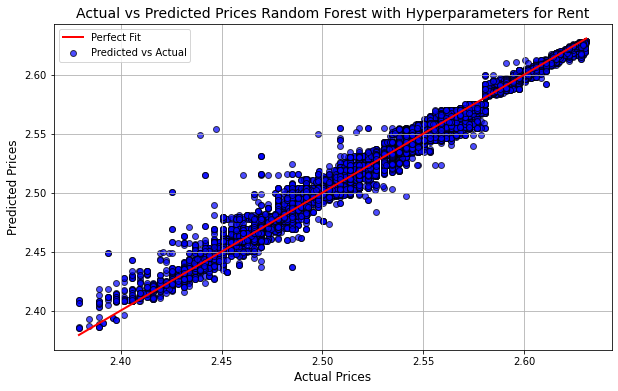

In [112]:
# Initialize the random forest with hyperparameters
model_random_r_hyper = RandomForestRegressor(n_estimators=1000, max_depth=8, random_state=42)
model_random_r_hyper.fit(X_train, y_train)

y_pred_rf_hyper = model_random_r_hyper.predict(X_test)

#evaluting model th random forest hyperparameter
mse_rf_hyper = mean_squared_error(y_test, y_pred_rf_hyper)
mae_rf_hyper = mean_absolute_error(y_test, y_pred_rf_hyper)
r2_random_hyper = r2_score(y_test, y_pred_rf_hyper)
rmse_rf_hyper = np.sqrt(mse_rf_hyper)


y_train_pred = model_random_r_hyper.predict(X_train)

# Calculate regression metrics for training set
r2_train_randomhyper_rent = r2_score(y_train, y_train_pred)
print(f"Training R2 Score of rent hyperparameter: {r2_train_randomhyper_rent}")

print(f"R2 (Random Forest with Hyperparameters): {r2_random_hyper}")
print(f"Mean Absolute Error (MAE) Random Forest with Hyperparameters for Rent: {mae_rf_hyper}")
print(f"Mean Squared Error (MSE) Random Forest with Hyperparameters for Rent: {mse_rf_hyper}")
print(f"Root Mean Squared Error (RMSE) Random Forest with Hyperparameters for Rent: {rmse_rf_hyper}")

# Plotting the Actual vs Predicted values random forest hyperparameter
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf_hyper, color='blue', edgecolors='k', alpha=0.7, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2, label='Perfect Fit')

plt.title('Actual vs Predicted Prices Random Forest with Hyperparameters for Rent', fontsize=14)
plt.xlabel('Actual Prices', fontsize=12)
plt.ylabel('Predicted Prices', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Decision Tree 

Training R2 Score of rent: 0.9999999999994831
R2 Score  for sales: 0.9993493863403621
Mean Absolute Error of Decision Tree to rent: 0.00014301850269095003
Mean Squared Error of Decision Tree to rent: 1.630524708262585e-06
Root Mean Squared Error Decision Tree  to rent: 0.0012769200085606715


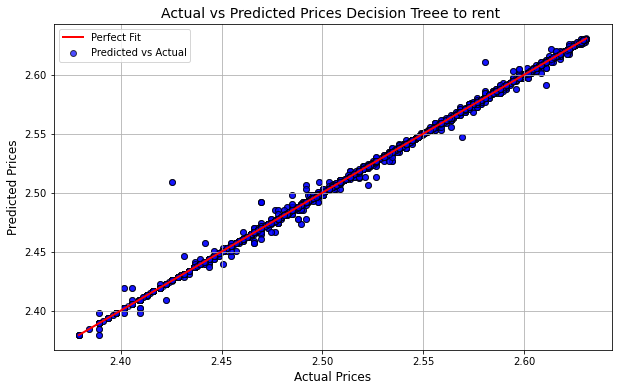

In [113]:
# Defining the model Decision tree for rent
model_tree = DecisionTreeRegressor(random_state=42)

# Fitting the model on the training data
model_tree.fit(X_train, y_train)

# Predicting using the testing data rent 
y_pred = model_tree.predict(X_test)

# Calculate metrcs to rent data 
mae_tree = mean_absolute_error(y_test, y_pred)
mse_tree = mean_squared_error(y_test, y_pred)
rmse_tree = np.sqrt(mse_tree)
r2_tree = r2_score(y_test, y_pred)

y_train_pred = model_tree.predict(X_train)

# Calculate regression metrics for training set
r2_train_d_rent = r2_score(y_train, y_train_pred)
print(f"Training R2 Score of rent: {r2_train_d_rent}")

print(f"R2 Score  for sales: {r2_tree}")
print(f"Mean Absolute Error of Decision Tree to rent: {mae_tree}")
print(f"Mean Squared Error of Decision Tree to rent: {mse_tree}")
print(f"Root Mean Squared Error Decision Tree  to rent: {rmse_tree}")

# Plotting the Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolors='k', alpha=0.7, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2, label='Perfect Fit')

# Adding titles and labels
plt.title('Actual vs Predicted Prices Decision Treee to rent ', fontsize=14)
plt.xlabel('Actual Prices', fontsize=12)
plt.ylabel('Predicted Prices', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


Training R2 Score of rent hyperparameter: 0.9778366363344971
R² Score for rent: 0.9733866572372849
Mean Absolute Error of Decision Tree for rent: 0.005586001170324907
Mean Squared Error of Decision Tree for rent: 6.669659067443987e-05
Root Mean Squared Error of Decision Tree for rent: 0.00816679806744601


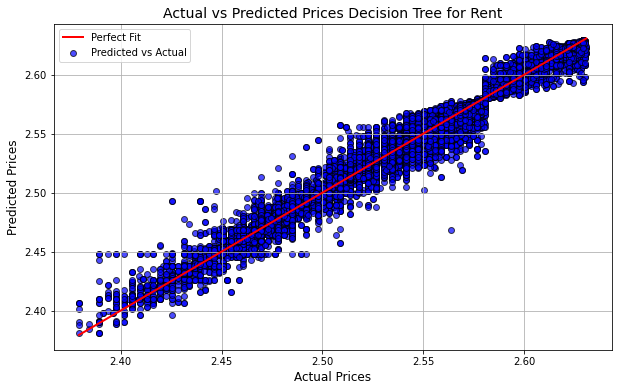

In [114]:
# Maximum depth of the tree
# Minimum samples required to split a node
 # Minimum samples required at a leaf node
# Consider a subset of features when splitting nodes
# Initialize DecisionTreeRegressor with below hyperparameters
best_tree = DecisionTreeRegressor(
    max_depth=15,            
    min_samples_split=5,     
    min_samples_leaf=6,     
    max_features='sqrt',     
    random_state=42          
)


# Fit the model to the training data on rent
best_tree.fit(X_train, y_train)

# Make predictions using the trained model hyperpameter rent
y_pred_best_tree = best_tree.predict(X_test)

# Calculate metrics
mae_tree_h = mean_absolute_error(y_test, y_pred_best_tree)
mse_tree_h = mean_squared_error(y_test, y_pred_best_tree)
rmse_tree_h = np.sqrt(mse_tree_h)
r2_tree_h = r2_score(y_test, y_pred_best_tree)

y_train_pred = best_tree.predict(X_train)

# Calculate regression metrics for training set
r2_train_dhyper_rent = r2_score(y_train, y_train_pred)
print(f"Training R2 Score of rent hyperparameter: {r2_train_dhyper_rent}")

print(f"R² Score for rent: {r2_tree_h}")
print(f"Mean Absolute Error of Decision Tree for rent: {mae_tree_h}")
print(f"Mean Squared Error of Decision Tree for rent: {mse_tree_h}")
print(f"Root Mean Squared Error of Decision Tree for rent: {rmse_tree_h}")

# Plotting the Actual vs Predicted values of hyperparameter rent
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best_tree, color='blue', edgecolors='k', alpha=0.7, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2, label='Perfect Fit')

plt.title('Actual vs Predicted Prices Decision Tree for Rent', fontsize=14)
plt.xlabel('Actual Prices', fontsize=12)
plt.ylabel('Predicted Prices', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [115]:
# Table format to display the model
metrics_dict_rent = {
    'Model': ['R Regression', 'Lasso Regression', 'Best Lasso (alpha)', 
              'XGBoost', 'XGBoost [Hyperparameter]', 'Random Forest', 
              'Random Forest [Hyperparameter]', 'Decision Tree', 'Decision Tree [Hyperparameter]'],
    'R2 Score': [r2_r_reg, r2_rent_l, r2_lasso_alpha, r2_xr, r2_xr_hyper, 
                 r2_random, r2_random_hyper, r2_tree, r2_tree_h],
    'Mean Absolute Error (MAE)': [mae_r_reg, mae_r_l, mae_lasso_alpha, mae_xr, 
                                  mae_xr_hyper, mae_rf, mae_rf_hyper, mae_tree, mae_tree_h],
    'Mean Squared Error (MSE)': [mse_r_reg, mse_r_l, mse_best_lasso_alpha, mse_xr, 
                                 mse_xr_hyper, mse_rf, mse_rf_hyper, mse_tree, mse_tree_h],
    'Root Mean Squared Error (RMSE)': [rmse_r_reg, rmse_r_l, rmse_lasso_alpha, rmse_xr, 
                                       rmse_xr_hyper, rmse_rf, rmse_rf_hyper, rmse_tree, rmse_tree_h]
}

# Create DataFrame and display
metrics_df = pd.DataFrame(metrics_dict_rent)
print(metrics_df)

                            Model  R2 Score  Mean Absolute Error (MAE)  \
0                    R Regression  0.823155                   0.015883   
1                Lasso Regression  0.595021                   0.025685   
2              Best Lasso (alpha)  0.803613                   0.017255   
3                         XGBoost  0.999182                   0.001012   
4        XGBoost [Hyperparameter]  0.965370                   0.007493   
5                   Random Forest  0.999581                   0.000237   
6  Random Forest [Hyperparameter]  0.983067                   0.004472   
7                   Decision Tree  0.999349                   0.000143   
8  Decision Tree [Hyperparameter]  0.973387                   0.005586   

   Mean Squared Error (MSE)  Root Mean Squared Error (RMSE)  
0                  0.000443                        0.021052  
1                  0.001015                        0.031858  
2                  0.000492                        0.022185  
3          

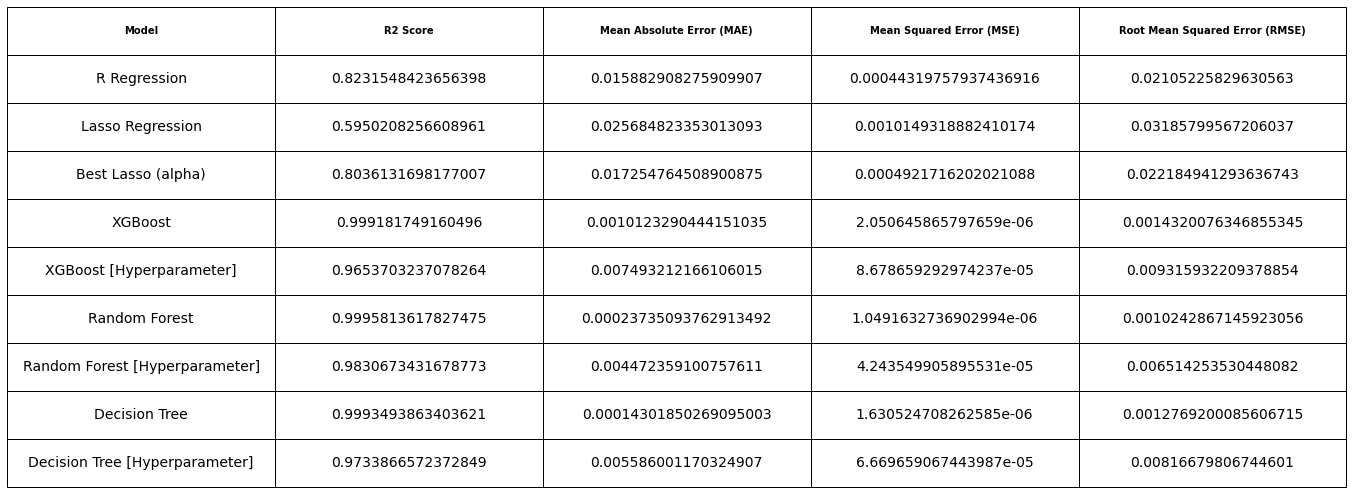

In [116]:
# Created figure and axis for the evalution table
fig, ax = plt.subplots(figsize=(12, 4))  
ax.axis('tight')
ax.axis('off')
table_rent = ax.table(cellText=metrics_df.values,
                 colLabels=metrics_df.columns,
                 cellLoc='center',
                 loc='center')
#Styling
table_rent.auto_set_font_size(False)
table_rent.set_fontsize(10)  # Set a larger font size for all text
table_rent.scale(2, 4)

#header bold and increase its font size
for (i, j), cell in table_rent.get_celld().items():
    if i == 0:  # Header row
        cell.set_text_props(fontweight='bold', fontsize=10)  # Set header text to bold and larger
    else:
        cell.set_fontsize(14)  # Set the body text to a larger size
plt.show()

In [120]:
#building the model for rent with input layer, hidden layer and output layer
rent_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  
    layers.Dense(32, activation='relu'),  
    layers.Dense(1)  
])

rent_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

#training model for rent
h_rent = rent_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

#evaluating the model for rent
rent_test_loss, rent_test_mae = rent_model.evaluate(X_test, y_test)
y_rent_pred = rent_model.predict(X_test).flatten()

#metrics MSE for rent
rent_mse = np.mean((y_test - y_rent_pred) ** 2)

#calculating RMSE for rent
rent_rmse = np.sqrt(rent_mse)

#calculating AMSE for rent
# n is obervations and p is features
n = X_test.shape[0]  
p = X_test.shape[1]  
rent_amse = rent_mse * (n / (n - p))

#calculating R2 for rent
ss_res_rent = np.sum((y_test - y_rent_pred) ** 2)
ss_tot_rent = np.sum((y_test - np.mean(y_test)) ** 2)
rent_r2_score = 1 - (ss_res_rent / ss_tot_rent)

#display metrics & results for rent
print(f'Test MAE (Rent): {rent_test_mae}')
print(f'Test RMSE (Rent): {rent_rmse}')
print(f'Test AMSE (Rent): {rent_amse}')
print(f'R² Score (Rent): {rent_r2_score}')


Epoch 1/10
1208/1208 [==============================] - 9s 6ms/step - loss: 0.1013 - mae: 0.1696 - val_loss: 0.0046 - val_mae: 0.0443
Epoch 2/10
1208/1208 [==============================] - 7s 6ms/step - loss: 0.0118 - mae: 0.0794 - val_loss: 0.0119 - val_mae: 0.0959
Epoch 3/10
1208/1208 [==============================] - 5s 4ms/step - loss: 0.0185 - mae: 0.0677 - val_loss: 0.0027 - val_mae: 0.0339
Epoch 4/10
1208/1208 [==============================] - 6s 5ms/step - loss: 0.0076 - mae: 0.0608 - val_loss: 0.0021 - val_mae: 0.0281
Epoch 5/10
1208/1208 [==============================] - 6s 5ms/step - loss: 0.0088 - mae: 0.0643 - val_loss: 0.0018 - val_mae: 0.0260
Epoch 6/10
1208/1208 [==============================] - 6s 5ms/step - loss: 0.0079 - mae: 0.0623 - val_loss: 0.0032 - val_mae: 0.0465
Epoch 7/10
1208/1208 [==============================] - 6s 5ms/step - loss: 0.0061 - mae: 0.0549 - val_loss: 0.0015 - val_mae: 0.0257
Epoch 8/10
1208/1208 [==============================] - 6s 5ms

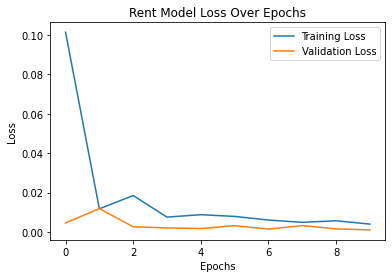

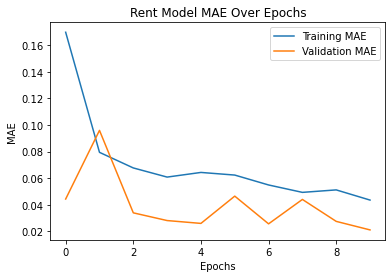

In [122]:
# vsualizing the training and validation loss over epochs for rent
plt.plot(h_rent.history['loss'], label='Training Loss')
plt.plot(h_rent.history['val_loss'], label='Validation Loss')
plt.title('Rent Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualizing the training and validation MAE over epochs for rent
plt.plot(h_rent.history['mae'], label='Training MAE')
plt.plot(h_rent.history['val_mae'], label='Validation MAE')
plt.title('Rent Model MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


# Thank you